# pix2pix Model
## Direction：Google Map -> Satellite Image

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from datetime import datetime 
from keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
from os.path import isfile, join

## 1.1 Discriminator

During training, the discriminator determines whether a given Google Map is the real map corresponding to a satellite image or a generated (fake) one.

The discriminator adopts PatchGAN. Instead of directly deciding whether the entire image is real or fake, PatchGAN divides the image into multiple smaller patch regions and evaluates each patch independently.

Finally, by aggregating the results from all local patches, the discriminator outputs a decision for the whole image: 1 indicates a real Google Map, and 0 indicates a generated (fake) Google Map.

In [2]:
# Define a discriminator model, whose task is to distinguish between generated images and real images
def define_discriminator(image_shape):
    # Initialize convolutional kernel weights with a normal distribution (stddev=0.02)
    init = RandomNormal(stddev=0.02)
    
    # Input source image (satellite image)
    in_src_image = Input(shape=image_shape)
    # Input target image (the corresponding real Google Map)
    in_target_image = Input(shape=image_shape)
    
    # Concatenate the satellite image and the real map along the channel dimension (depth).
    # Satellite image size: (256,256,3)
    # Real Google Map size: (256,256,3)
    # After concatenation: (256,256,6)
    # This way, the network simultaneously receives both images and learns how to map
    # from satellite imagery to Google Maps.
    merged = Concatenate()([in_src_image, in_target_image])
    
    # The discriminator is a CNN that extracts spatial features to judge if a map is real or fake.
    # First convolutional block: 64 filters, kernel 4x4, stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    # LeakyReLU allows a small gradient for negative values (output = max(αx, x))
    d = LeakyReLU(alpha=0.2)(d)

    # C128: 128 filters, kernel 4x4, stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)  # normalize inputs to stabilize training and avoid gradient issues
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256: 256 filters, kernel 4x4, stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512: 512 filters, kernel 4x4, stride 2x2
    # (Optional: not in the original paper, can be commented out)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # Second-to-last layer: 512 filters, kernel 4x4, stride 1x1
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # Final convolution: compresses multiple channels into 1 channel
    # Output shape: (batch_size, height, width, 1)
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    
    # Sigmoid activation maps each element in the output matrix to [0,1]
    # patch_out represents the authenticity score of each patch
    patch_out = Activation('sigmoid')(d)
    
    # Define the discriminator model
    # Inputs: source image (satellite) + target image (real map)
    # Output: patch_out matrix with authenticity scores in [0,1]
    model = Model([in_src_image, in_target_image], patch_out)
    
    # Compile the model
    # Optimizer: Adam with lr=0.0002, beta_1=0.5
    # Loss: binary crossentropy (since outputs are probabilities: 0 or 1)
    # loss_weights=[0.5] balances discriminator and generator updates equally (50/50)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


## 2.1 Generator

The generator adopts a U-Net architecture,

where the encoder performs downsampling and the decoder performs upsampling.

In [3]:
# Encoder: performs downsampling to extract complex features and gradually reduce image size
'''
Arguments:
layer_in  : feature map from the previous layer
n_filters : number of filters in the convolution, determines output feature map depth
batchnorm : whether to apply batch normalization after convolution (helps speed up convergence)
'''
def encoder_block(layer_in, n_filters, batchnorm=True):
    # Initialize convolution weights
    init = RandomNormal(stddev=0.02)
    # Downsampling with a 4x4 convolution, stride 2x2
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # Apply batch normalization (optional)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # LeakyReLU activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


'''
Arguments:
layer_in  : feature map input to the decoder
skip_in   : skip connection input from the encoder
n_filters : number of filters in the transposed convolution
dropout   : whether to apply dropout for regularization (prevent overfitting)
'''
# Decoder: performs upsampling, recovers spatial information using skip connections from the encoder
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # Initialize weights
    init = RandomNormal(stddev=0.02)
    # Upsampling with transposed convolution (Conv2DTranspose)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # Batch normalization
    g = BatchNormalization()(g, training=True)
    # Optional dropout for regularization
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # Concatenate decoder features with encoder features (skip connection)
    # Skip connections carry fine-grained details lost during downsampling
    g = Concatenate()([g, skip_in])
    # ReLU activation
    g = Activation('relu')(g)
    return g


# Define the generator model (U-Net architecture)
def define_generator(image_shape=(256,256,3)):
    # Initialize weights
    init = RandomNormal(stddev=0.02)
    # Input: satellite image of size 256x256x3
    in_image = Input(shape=image_shape)
    
    # Encoder: series of downsampling blocks
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)

    # Bottleneck: compresses the encoded features for further abstraction
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    # Decoder: upsampling + skip connections
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # Final upsampling layer: expand feature map back to input resolution
    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    
    # Tanh activation: map outputs to [-1, 1], consistent with normalized input range
    out_image = Activation('tanh')(g)

    # Input: satellite image, Output: generated Google Map
    model = Model(in_image, out_image)
    return model


## 3.1 Define cGAN Architecture

In [4]:
# Define the GAN, which takes three arguments: generator model, discriminator model, and input image shape
def define_gan(g_model, d_model, image_shape):
    # When training the generator, only update its weights
    # Freeze the discriminator's weights to prevent it from interfering with generator training
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False  # Prevent discriminator parameter updates
    
    # Input: satellite image
    in_src = Input(shape=image_shape)
    # Pass the satellite image through the generator to produce the corresponding Google Map
    gen_out = g_model(in_src)
    # Pass both satellite image and generated Google Map into the discriminator
    # The discriminator outputs dis_out: its estimate of whether the generated map is real
    # During training, the generator tries to make dis_out close to 1, i.e., generate images realistic enough to fool the discriminator
    dis_out = d_model([in_src, gen_out])
    
    # Define the combined GAN model
    # Inputs: in_src (satellite image)
    # Outputs: [dis_out, gen_out]
    # - dis_out: discriminator's assessment of gen_out
    # - gen_out: the generated Google Map
    model = Model(in_src, [dis_out, gen_out])
    
    # Compile the GAN
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # Total loss = weighted sum of adversarial loss (binary crossentropy) and L1 loss (mean absolute error)
    # The authors suggest weighting BCE vs. L1 as 1:100
    model.compile(loss=['binary_crossentropy', 'mae'], 
                  optimizer=opt, loss_weights=[1,100])
    return model


In [5]:


# Generate a batch of real samples for training the discriminator
def generate_real_samples(dataset, n_samples, patch_shape):
    # dataset contains two arrays: typically input-output image pairs
    # patch_shape: size of the discriminator's output feature map

    trainA, trainB = dataset  # trainA = satellite images, trainB = corresponding target Google Maps
    
    # Randomly select n_samples indices
    ix = randint(0, trainA.shape[0], n_samples)
    
    # Extract images at the selected indices
    # X1: satellite image samples from trainA
    # X2: corresponding Google Map samples from trainB
    X1, X2 = trainA[ix], trainB[ix]
    
    # Generate labels for real samples (all ones)
    # Shape: (n_samples, patch_shape, patch_shape, 1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    
    # Return paired satellite-GoogleMap images and their labels
    return [X1, X2], y


# Generate a batch of fake samples for training the discriminator
def generate_fake_samples(g_model, samples, patch_shape):
    # Use generator model g_model to generate fake images from input samples
    # Here, input samples are satellite images; output is fake Google Maps
    X = g_model.predict(samples)
    
    # Generate labels for fake samples (all zeros)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y


In [6]:
# Periodically generate sample images and save the generator model during training
def summarize_performance(step, g_model, dataset, n_samples=3):

    # Get real sample pairs: Satellite image - GoogleMap
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    
    # Use the generator model (g_model) to convert the satellite image X_realA 
    # into a fake GoogleMap X_fakeB
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    
    # Normalize pixel values
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # Plot images:
    # The first row: real input satellite images (source images)
    # The second row: generated target GoogleMap images (X_fakeB)
    # The third row: real target GoogleMap images (X_realB)
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])

    # Save the plotted images to a file, with the filename based on the current step
    # This allows visual tracking of training progress.
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()

    # Save the generator model (g_model) to a file to record its training state.
    # The filename includes the step number for easy reference.
    filename2 = 'Map2SatModel_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))


## Train

In [7]:
# Train Pix2Pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    """
    d_model: Discriminator model
    g_model: Generator model
    gan_model: Combined GAN model (generator + discriminator)
    dataset: Dataset containing source images (datasetA, satellite images) 
             and target images (datasetB, target maps)
    n_epochs: Total number of training epochs
    n_batch: Number of samples per batch
    """
    # In GAN training, the discriminator judges whether each patch of the generated image is real.
    # The patch size is determined here.
    n_patch = d_model.output_shape[1]

    # Split dataset -> satellite images (trainA) and Google Maps (trainB)
    trainA, trainB = dataset
    # Calculate the number of batches per epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # Calculate total training steps
    n_steps = bat_per_epo * n_epochs

    for i in range(n_steps):

        # Get one batch of real sample pairs (X_realA, X_realB) and their labels y_real
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

        # Generate fake samples: use g_model to create X_fakeB from X_realA
        # Assign label y_fake = 0 for fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

        # Train the discriminator on real samples
        # Input: (real satellite image, real Google Map, real label)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

        # Train the discriminator on fake samples
        # Input: (real satellite image, fake Google Map, fake label)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        # Update the generator via the composite GAN model
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        # Print performance every 50 training steps
        if (i + 1) % 250 == 0:
            print('step[%d], d1_loss:[%.3f] d2_loss:[%.3f] generator_loss[%.3f]' % (i + 1, d_loss1, d_loss2, g_loss))
            
            # Visualize the source, generated, and target images
            # Choose a sample from the current batch
            sample_idx = 0  # Change this index to view other images in the batch
            src_image = (X_realA[sample_idx] + 1) / 2.0  # Rescale image to [0,1]
            gen_image = (X_fakeB[sample_idx] + 1) / 2.0  # Rescale image to [0,1]
            tar_image = (X_realB[sample_idx] + 1) / 2.0  # Rescale image to [0,1]
            
            # Plot the images in a row: source, generated, target
            plt.figure(figsize=(10, 5))
            titles = ['Source', 'Generated', 'Target']
            images = [src_image, gen_image, tar_image]
            
            for j in range(3):
                plt.subplot(1, 3, j + 1)
                plt.imshow(images[j])
                plt.axis('off')
                plt.title(titles[j])
            
            plt.show()
            
        # Summarize and save model performance periodically
        if (i + 1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)


In [8]:
def load_images(path, size=(256,512)):
    src_list, tar_list = [], []
    
    for filename in listdir(path):
        full_path = join(path, filename)
        # Skip directories or non-image files
        if not isfile(full_path) or not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        
        # Load and split image
        pixels = load_img(full_path, target_size=size)
        pixels = img_to_array(pixels)
        
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(map_img)
        tar_list.append(sat_img)
    
    return [asarray(src_list), asarray(tar_list)]

# Dataset path
path = 'maps/train/'

# Load dataset
[src_images, tar_images] = load_images(path)

# Print dataset shapes
print('Loaded: ', src_images.shape, tar_images.shape)


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


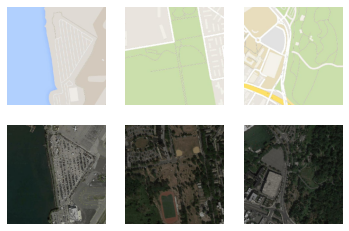

In [9]:
# Randomly select indices for n_samples pairs of images
n_samples = 3
random_indices = np.random.choice(src_images.shape[0], n_samples, replace=False)

# Randomly selected source and target images
src_images_sample = src_images[random_indices]
tar_images_sample = tar_images[random_indices]

# Plot the randomly selected source images
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)  # Select the i-th position in a 2-row, n_samples-column layout
    pyplot.axis('off')  # Hide the axis
    pyplot.imshow(src_images_sample[i].astype('uint8'))  # Display the i-th source (satellite) image, converted to uint8

# Plot the corresponding target images
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)  # Add target images to the same figure
    pyplot.axis('off')  # Hide the axis
    pyplot.imshow(tar_images_sample[i].astype('uint8'))  # Display the i-th target (map) image

# Show all images
pyplot.show()


2025-10-05 04:27:49.341587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 04:27:50.070776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:38:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2025-10-05 04:27:53.437286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2025-10-05 04:27:54.800571: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Fal

step[250], d1_loss:[0.003] d2_loss:[0.024] generator_loss[24.189]


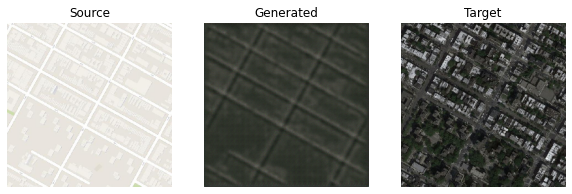

step[500], d1_loss:[0.996] d2_loss:[0.486] generator_loss[9.323]


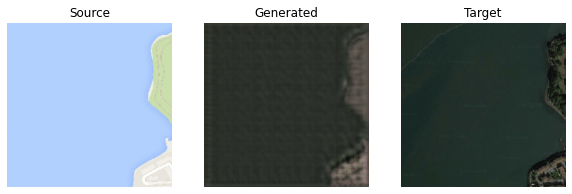

step[750], d1_loss:[0.001] d2_loss:[0.025] generator_loss[31.356]


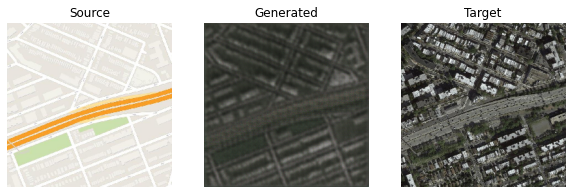

step[1000], d1_loss:[0.005] d2_loss:[0.073] generator_loss[29.457]


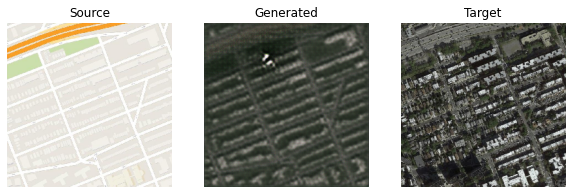

step[1250], d1_loss:[0.159] d2_loss:[0.065] generator_loss[11.184]


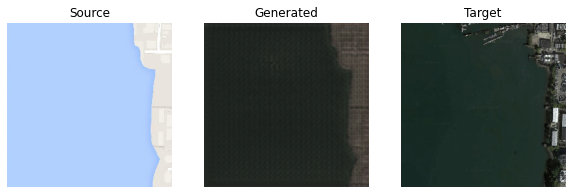

step[1500], d1_loss:[0.003] d2_loss:[0.030] generator_loss[28.919]


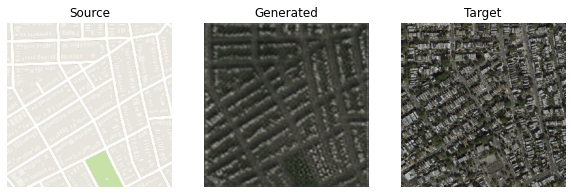

step[1750], d1_loss:[0.001] d2_loss:[0.023] generator_loss[25.993]


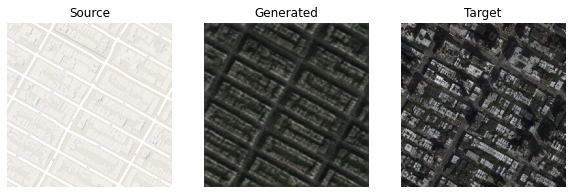

step[2000], d1_loss:[0.008] d2_loss:[0.034] generator_loss[25.003]


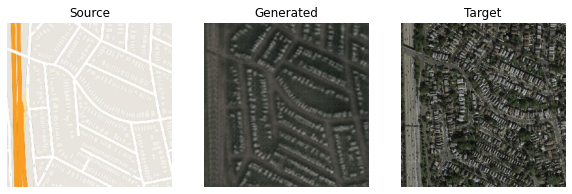

step[2250], d1_loss:[0.004] d2_loss:[0.031] generator_loss[25.433]


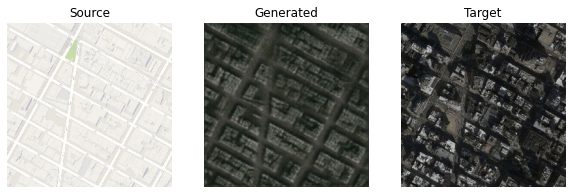

step[2500], d1_loss:[0.002] d2_loss:[0.017] generator_loss[28.242]


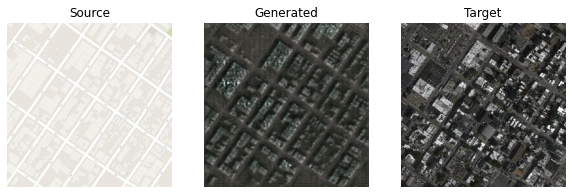

step[2750], d1_loss:[0.004] d2_loss:[0.030] generator_loss[23.864]


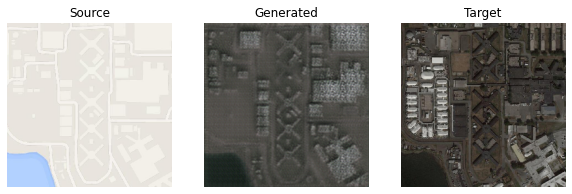

step[3000], d1_loss:[0.004] d2_loss:[0.017] generator_loss[25.517]


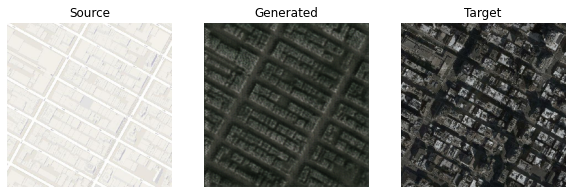

step[3250], d1_loss:[1.055] d2_loss:[0.236] generator_loss[10.687]


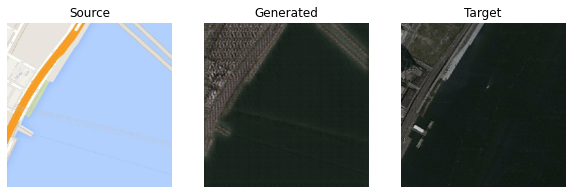

step[3500], d1_loss:[0.812] d2_loss:[0.252] generator_loss[11.313]


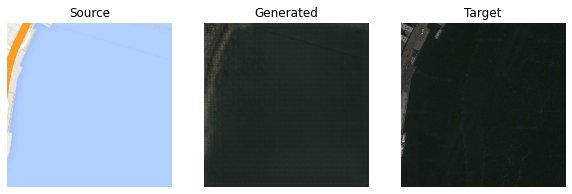

step[3750], d1_loss:[0.665] d2_loss:[0.160] generator_loss[12.668]


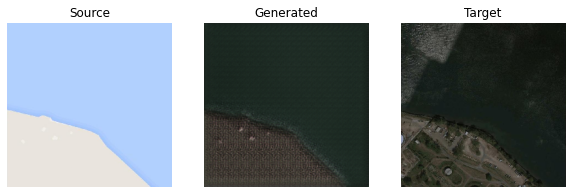

step[4000], d1_loss:[0.576] d2_loss:[0.330] generator_loss[12.090]


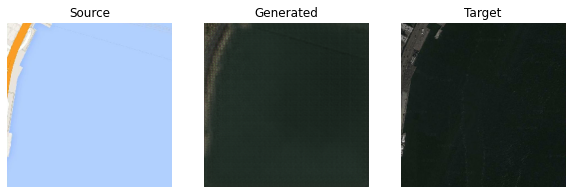

step[4250], d1_loss:[0.009] d2_loss:[0.027] generator_loss[21.447]


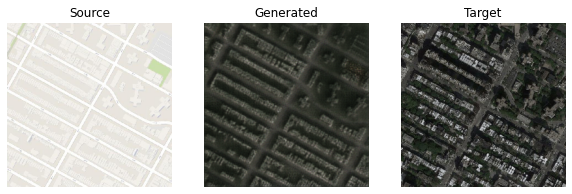

step[4500], d1_loss:[0.015] d2_loss:[0.019] generator_loss[28.130]


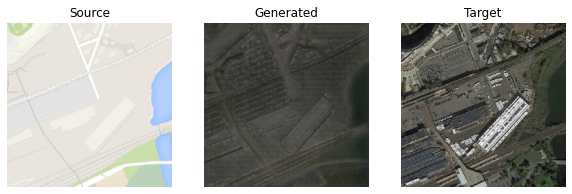

step[4750], d1_loss:[0.030] d2_loss:[0.055] generator_loss[21.375]


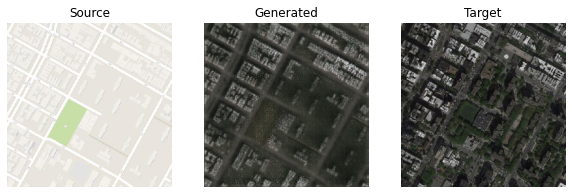

step[5000], d1_loss:[0.042] d2_loss:[0.059] generator_loss[9.276]


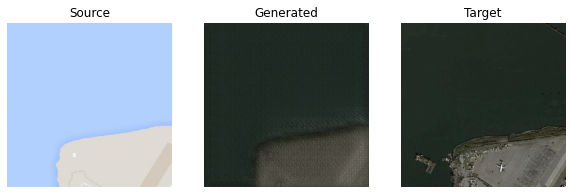

step[5250], d1_loss:[0.014] d2_loss:[0.145] generator_loss[30.267]


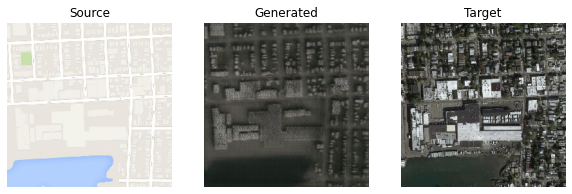

step[5500], d1_loss:[0.036] d2_loss:[0.075] generator_loss[18.876]


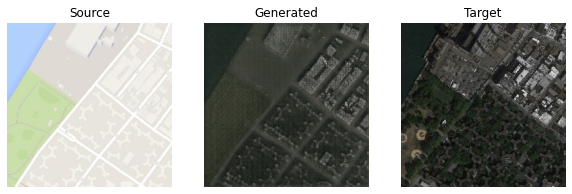

step[5750], d1_loss:[0.014] d2_loss:[0.047] generator_loss[24.888]


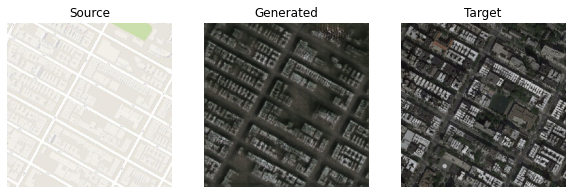

step[6000], d1_loss:[0.496] d2_loss:[0.048] generator_loss[28.807]


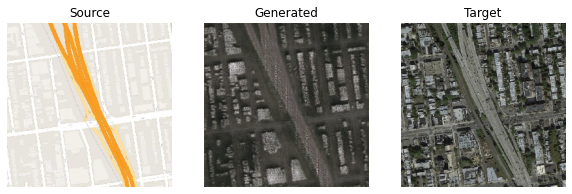

step[6250], d1_loss:[0.158] d2_loss:[0.082] generator_loss[20.094]


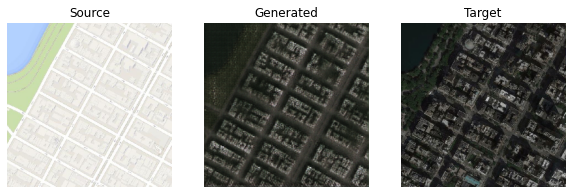

step[6500], d1_loss:[0.149] d2_loss:[0.201] generator_loss[13.200]


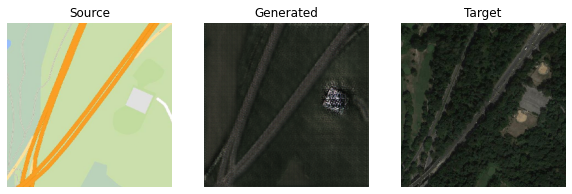

step[6750], d1_loss:[0.007] d2_loss:[0.030] generator_loss[26.102]


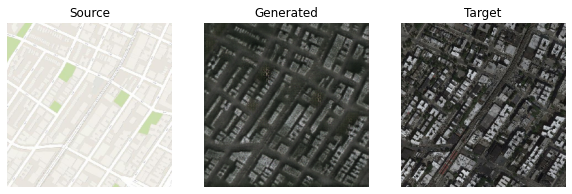

step[7000], d1_loss:[0.004] d2_loss:[0.202] generator_loss[29.070]


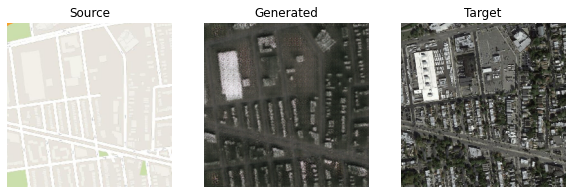

step[7250], d1_loss:[0.012] d2_loss:[0.062] generator_loss[32.493]


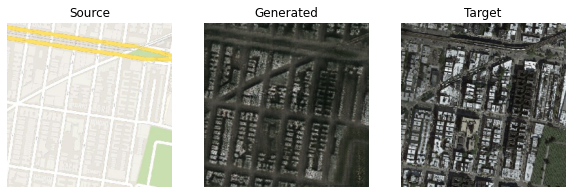

step[7500], d1_loss:[0.014] d2_loss:[0.028] generator_loss[26.106]


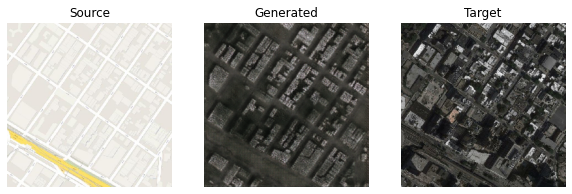

step[7750], d1_loss:[0.014] d2_loss:[0.060] generator_loss[26.178]


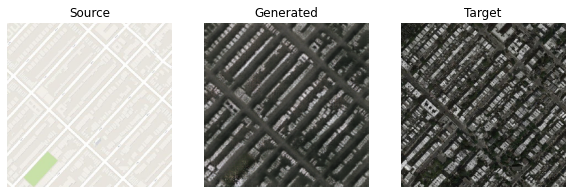

step[8000], d1_loss:[0.012] d2_loss:[0.057] generator_loss[21.238]


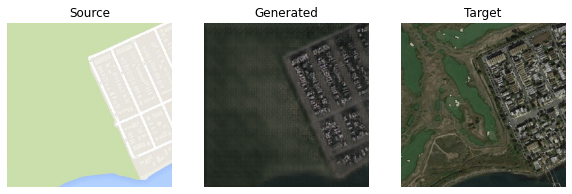

step[8250], d1_loss:[0.019] d2_loss:[0.024] generator_loss[16.405]


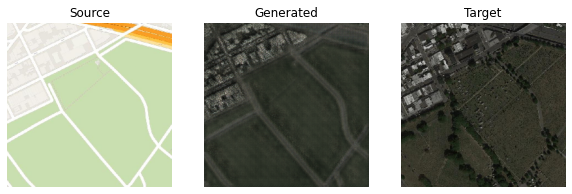

step[8500], d1_loss:[0.009] d2_loss:[0.031] generator_loss[20.510]


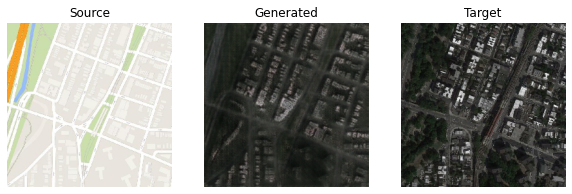

step[8750], d1_loss:[0.019] d2_loss:[0.024] generator_loss[24.187]


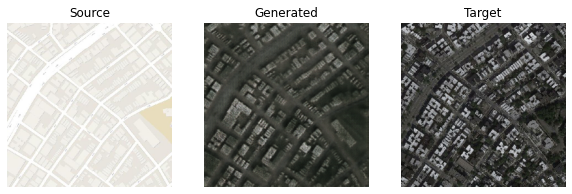

step[9000], d1_loss:[0.009] d2_loss:[0.144] generator_loss[23.856]


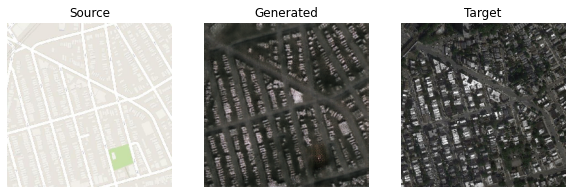

step[9250], d1_loss:[0.009] d2_loss:[0.022] generator_loss[24.686]


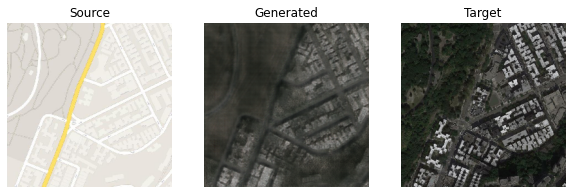

step[9500], d1_loss:[0.011] d2_loss:[0.046] generator_loss[17.880]


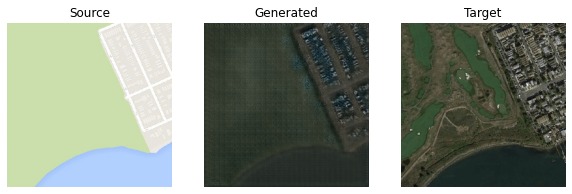

step[9750], d1_loss:[0.010] d2_loss:[0.027] generator_loss[25.318]


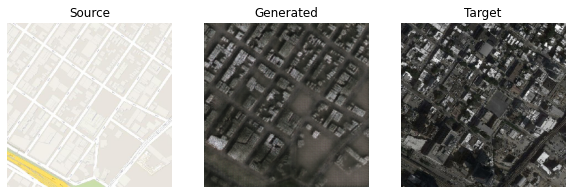

step[10000], d1_loss:[0.092] d2_loss:[0.157] generator_loss[14.280]


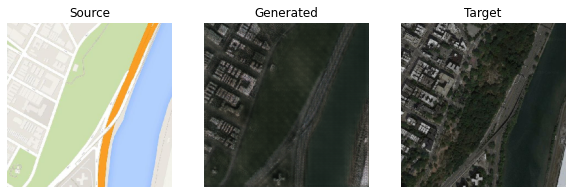

step[10250], d1_loss:[0.014] d2_loss:[0.237] generator_loss[19.712]


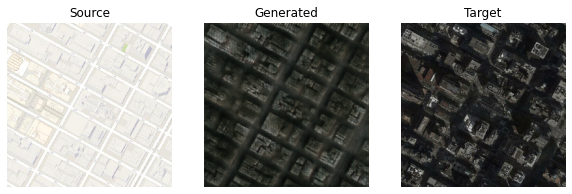

step[10500], d1_loss:[0.018] d2_loss:[0.036] generator_loss[22.887]


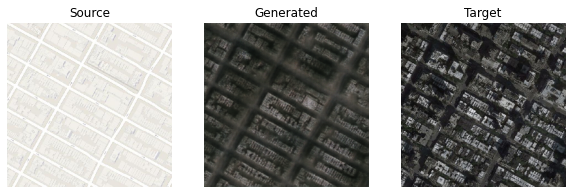

step[10750], d1_loss:[0.008] d2_loss:[0.025] generator_loss[21.499]


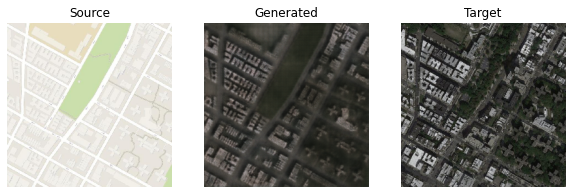

>Saved: plot_010960.png and Map2SatModel_010960.h5
Execution time is:  0:28:03.563930


In [10]:
# from pix2pix_model import define_discriminator, define_generator, define_gan, train
# Get the image dimensions; the input image shape is (256, 256, 3)
image_shape = src_images.shape[1:]

# Define the discriminator and generator
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# Define the combined GAN model
gan_model = define_gan(g_model, d_model, image_shape)

data = [src_images, tar_images]  # Satellite images and Google Maps

def preprocess_data(data):
    # Data preprocessing: scale images from [0, 255] to [-1, 1]
    X1, X2 = data[0], data[1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)


user_choice = 'train model'
if user_choice == 'train model':
    start1 = datetime.now() 
    train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) 
    stop1 = datetime.now()
    execution_time = stop1 - start1
    print("Execution time is: ", execution_time)
else:
    print("Use pretrained model directly")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Average SSIM for 200 image pairs: 0.5779
Average PSNR for 200 image pairs: 22.4728


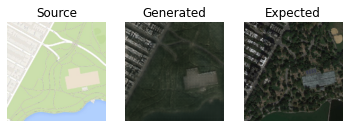

In [11]:
# Load the pre-trained model
model = load_model('pix2pix_Map2SatModel.h5')

# Function to plot images and calculate SSIM and PSNR for a single pair
def plot_images(src_img, gen_img, tar_img):
    images = np.vstack((src_img, gen_img, tar_img))
    # Rescale images from [-1, 1] to [0, 1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    
    # Plot images row by row
    for i in range(len(images)):
        plt.subplot(1, 3, 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])

    # Resize images if they are too small
    tar_img_resized = resize(tar_img[0], (64, 64), mode='reflect', anti_aliasing=True)
    gen_img_resized = resize(gen_img[0], (64, 64), mode='reflect', anti_aliasing=True)

    # Rescale images to [0, 255] range for SSIM and PSNR
    tar_img_uint8 = ((tar_img_resized + 1) * 127.5).astype(np.uint8)
    gen_img_uint8 = ((gen_img_resized + 1) * 127.5).astype(np.uint8)

    # Calculate SSIM between generated and target images
    ssim_score, _ = ssim(tar_img_uint8, gen_img_uint8, full=True, multichannel=True, channel_axis=2)
    
    # Calculate PSNR between generated and target images
    psnr_score = psnr(tar_img_uint8, gen_img_uint8)

    return ssim_score, psnr_score

# Assume dataset contains X1 and X2 where X1 is the source images and X2 is the target images
[X1, X2] = dataset

# Initialize lists to store SSIM and PSNR scores
ssim_scores = []
psnr_scores = []

# Process 200 random pairs of images
for _ in range(100):
    ix = randint(0, len(X1), 1)
    src_image, tar_image = X1[ix], X2[ix]
    print(_)
    # Generate image from source
    gen_image = model.predict(src_image)

    # Calculate SSIM and PSNR for this pair and add them to the lists
    ssim_score, psnr_score = plot_images(src_image, gen_image, tar_image)
    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)

# Calculate the average SSIM and PSNR scores across all 200 pairs
average_ssim = np.mean(ssim_scores)
average_psnr = np.mean(psnr_scores)

print(f"Average SSIM for 200 image pairs: {average_ssim:.4f}")
print(f"Average PSNR for 200 image pairs: {average_psnr:.4f}")


SSIM : 0.5779
PSNR : 22.4728


(1, 256, 256, 3)

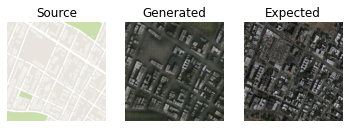

In [12]:
idx = [11]
src_image, tar_image = X1[idx], X2[idx]
gen_image = model.predict(src_image)
ssim_score, psnr_score = plot_images(src_image, gen_image, tar_image)
print(f"SSIM : {average_ssim:.4f}")
print(f"PSNR : {average_psnr:.4f}")
src_image.shape